# Zusatzprojekt - Blackbox KNN - Visualisierung von Entscheidungsreglen am Beispiel zur Identifizierung von Outliern mittels Autoencoder und Decision-Tree
Autor: Thomas Robert Holy
<br>
Versionsdatum 13.06.2020
<br>
Version 0.9
<br><br>
Visit me on GitHub: https://github.com/trh0ly

## Grundlegende Einstellungen:
### Import von Modulen
Zunächst müssen die notwendigen Module importiert werden, damit auf diese zugegriffen werden kann. 

In [10]:

#------------------------------
# Allgemein
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import auc
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from IPython.core.display import display, HTML
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import joblib
import operator
import os

#------------------------------
# KNN spezifisch
import tensorflow as tf
from keras import regularizers
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras import backend as K 

#------------------------------
# Decision Tree spezifisch 
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

#-------------------------------------
# pyod-spezifisch
import pyod 
from pyod.utils.data import evaluate_print
from pyod.models.auto_encoder import AutoEncoder
from pyod.utils.utility import precision_n_scores
from pyod.utils.data import generate_data, get_outliers_inliers


### Optikeinstellungen
Anschließend werden Einstellungen definiert, die die Formatierung der Ausgaben betreffen.
Hierfür wird das Modul `operator` genutzt.
Außerdem wird die Breite des im Folgenden genutzten DataFrames erhöht und die Größe der Grafiken modifiziert, welche später angezeigt werden sollen.

In [11]:

%%javascript
import IPython
IPython.OutputArea.auto_scroll_threshold = 9999;


<IPython.core.display.Javascript object>

In [12]:

display(HTML("<style>.container { width:100% !important; }</style>"))
pd.options.display.width = 500
pd.options.display.max_columns = 999
pd.options.display.max_rows = 999
SCREEN_WIDTH = 100
centered = operator.methodcaller('center', SCREEN_WIDTH)


### Einstellungen für die Reproduzierbarkeit

In [13]:

#----------------------------
# Seed value
seed_value= 0

#----------------------------
# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED']=str(seed_value)

#----------------------------
# 2. Set the `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)

#----------------------------
# 3. Set the `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

#----------------------------
# 4. Set the `tensorflow` pseudo-random generator at a fixed value
tf.random.set_seed(seed_value)

#----------------------------
# 5. Clear Keras Session
K.clear_session()


## Definition von Hilfsfunktionen
### Funktion zur Betrachtung der Konfusinsmatrix

In [14]:
"""
# Definition einer Funktion, welche eine Konfusionsmatrix und einen Klassifikationsreport
# zurückgibt. Die Konfusionsmatrix kann, wenn ein Wert für c gegeben ist, für beliebige 
# Werte von c betrachtet werden.
#------------
# Argumente:
# - X: DataFrame auf welchem die Prognose durchgefürt werden soll (ohne die Zielgröße)
# - y_true: Zum DataFrame X gehörige Werte der Zielgröße
# - model: Modell auf Basis dessen die Konfusionsmatrix berechnet werden soll
# - class_names: Bezeichnung für die Spalten des Dataframes (default=['0', '1'], mit 0 = negativ und 1 = positiv)
# - c:
# ---> Wenn None, dann wird die Konfusionsmatrix ohne die Einbeziehung von c bestimmt
# ---> Wenn != None, dann wird die Konfusionsmatrix in Abhängigkeit von c bestimmt
#------------
"""

def get_confusion_matrix(X, y_true, model, class_names=['0', '1'], c=None):
    
    #----------------------------
    # Vorgelagerte Berechnung falls ein Wert für c gegeben ist
    # und die Konfusionsmatrix für ein gegebenes c anpasst
    if c != None:
        pred_probability = model.predict_proba(X)
        pred_probability = pred_probability >= c
        y_pred = pred_probability[:, 1].astype(int)
    
    #----------------------------
    # Wenn kein Wert für c gegeben, dann führe Prognose 
    # lediglich auf Basis des Modells durch
    if c == None:
        y_pred = model.predict(X)
    
    #----------------------------
    # Berechnet die Konfusionsmatrix
    conf_mat = confusion_matrix(y_true, y_pred)
    
    #----------------------------
    # Überführung in einen DataFrame für eine bessere Übersichtlichkeit
    df_index = pd.MultiIndex.from_tuples([('Wahrer Wert', cn) for cn in class_names])
    df_cols = pd.MultiIndex.from_tuples([('Prognose des Modells', cn) for cn in class_names])
    df_conf_mat = pd.DataFrame(conf_mat, index=df_index, columns=df_cols)
    
    #----------------------------
    # Berechnet precision und recall
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)

    return df_conf_mat, classification_report(y_true, y_pred), precision, recall


### Funktion zur Betrachtung der ROC-Kurve

In [15]:
"""
# Definition einer Funktion, welche auf Basis eines gegeben Modells und zweier zusammengehöriger
# DataFrames die receiver operating characteristic curve (ROC-Curve) visualisiert
#------------
# Argumente:
# - X: DataFrame auf welchem die Prognose durchgefürt werden soll (ohne die Zielgröße)
# - y_true: Zum DataFrame X gehörige Werte der Zielgröße
# - model: Modell auf Basis dessen die ROC-Curve berechnet werden soll
#------------
"""

def roc_curve_func(X, y_true, model, predict=True):    
        
        #----------------------------
        # Berechnung FPR, TPR und AUC auf Basis des Modells  
        if predict == True:
            y_score = model.predict_proba(X)[:,1]       
            FPR, TPR, _ = roc_curve(y_true, y_score)
            AUC = auc(FPR, TPR)     
        else:
            FPR, TPR, thresholds = roc_curve(y_true=X, y_score=y_true)
            AUC = auc(FPR, TPR)
            
        #----------------------------
        # Darstellung als Grafik
        plt.figure()
        plt.plot(FPR, TPR, color='red', lw=2, label='ROC-Kurve (AUC = %0.5f)' % AUC)
        plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
        plt.xlim([-0.005, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC-Kurve')
        plt.legend(loc="lower right")
        plt.show()


### Funktion zum Skalieren der Daten

In [16]:
"""
# Definition einer Funktion, die die Skalierung der Daten vornimmt
#------------
# Argumente:
# - X: X Values
# - y: y Values
# - my_scaler: Zu verwendender Scaler zur Transformation
# - val:
# -> True: Scaler auf Daten fitten
# -> False: sclaer nicht auf Daten fitten, sondern lediglich mit Scaler transformieren
#------------
"""

def prepare_data(X, y, my_scaler=RobustScaler(), val=False):
    #--------------------------------
    # Define x and y data
    X = X.values
    y = y.values
    #--------------------------------
    # Scaling input data X
    if val == False:
        my_scaler.fit(X)
    X = my_scaler.transform(X)
    #--------------------------------
    # return X, y
    return X, y, my_scaler


### Funktion zum plotten der Modell-History des KNN

In [17]:
"""
# Definition einer Funktion, die die Skalierung der Daten vornimmt
#------------
# Argumente:
# - model: Definiertes Modell
# - epochs: Anzahl der Epochs
# - batch_size: Umfang der Batch-Size
# - X_train: Erklärende Features Traingsdatensatz
# - verbose: Einstellung Bericht während des Traings
#------------
"""

def history_func(model, X_train, X_test, verbose):

    #--------------------------------
    # Modell fitten
    history = model.fit(X_train, X_train,
                        verbose=verbose,
                        validation_data=(X_test, X_test),
                        ).history
    
    #--------------------------------
    # History plotten
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right');
    

### Funktion zur Evalutation des PyOD-Modells

In [18]:
"""
# Definition einer Funktion, welche auf Basis eines gegeben Modells und zweier zusammengehöriger
# DataFrames die receiver operating characteristic curve (ROC-Curve) visualisiert
#------------
# Argumente:
# - true: Wahre y-Werte
# - scores: Target scores
#------------
"""

def evaluate_func(model, true, scores):
        print('Model Information: {}'.format(model))
        #----------------------------        
        # evaluate and print the results
        print("\nEvaluation on Training Data:")
        evaluate_print('Scores:', true, scores)
        #----------------------------
        # Berechnung FPR, TPR und AUC auf Basis des Modells  
        fpr, tpr, thresholds = roc_curve(y_true=true, y_score=scores)
        AUC = auc(fpr, tpr)              
        #----------------------------
        # Darstellung als Grafik
        plt.figure()
        plt.plot(fpr, tpr, color='red', lw=2, label='ROC-Kurve (AUC = %0.4f)' % AUC)
        plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
        plt.xlim([-0.005, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC-Kurve')            
        plt.legend(loc="lower right")
        plt.show()
        

## Daten einlesen und vorbereiten
### Daten einlesen und beschreiben

In [19]:

data = pd.read_csv('train.csv', index_col=0)
data.head()


,Sensor_1,Sensor_2,Sensor_3,Sensor_4,Sensor_5,Sensor_6,Sensor_7,Sensor_8,Fehlerhaft
ID,,,,,,,,,
11447,-1.063966,-1.687783,-0.717894,-0.619762,-0.315555,0.970412,0.833393,-0.664237,0
30159,1.190018,-0.153891,0.244575,-0.945917,0.643541,-0.931910,0.105836,-0.912279,0
15224,-0.074293,0.232341,-0.115511,0.417505,0.605463,0.108488,-1.090736,0.391150,0
35269,-6.445610,3.193648,-3.214055,5.416042,-8.164125,-8.745973,-14.668771,-10.193530,1
6807,0.228074,0.150307,0.429958,-1.423343,0.751823,0.031458,-0.681521,-0.021216,0


In [20]:

print("Es befinden sich {} Outlier im eingelesenen Datensatz, welcher {} Einträge umfasst. Das sind {}%.".format(len(data.loc[data['Fehlerhaft'] == 1]),
                                                                                                                 len(data),
                                                                                                                 round(len(data.loc[data['Fehlerhaft'] == 1])/len(data), 5)))
data.describe()


Es befinden sich 284 Outlier im eingelesenen Datensatz, welcher 20492 Einträge umfasst. Das sind 0.01386%.


,Sensor_1,Sensor_2,Sensor_3,Sensor_4,Sensor_5,Sensor_6,Sensor_7,Sensor_8,Fehlerhaft
count,20492.000000,20492.000000,20492.000000,20492.000000,20492.000000,20492.000000,20492.000000,20492.000000,20492.000000
mean,-0.068472,0.040758,-0.022625,0.036005,-0.073756,-0.055509,-0.084735,-0.074226,0.013859
std,1.553701,1.504003,1.152375,1.131744,1.293978,1.345088,1.321553,1.306047,0.116909
min,-37.060311,-5.416315,-11.126624,-4.339319,-18.683715,-23.228255,-25.162799,-19.214325,0.000000
25%,-0.576847,-0.844764,-0.663308,-0.764438,-0.434557,-0.551374,-0.500618,-0.437655,0.000000
50%,0.030571,-0.005054,-0.059910,-0.035934,0.122958,-0.099117,-0.073644,0.052256,0.000000
75%,0.559258,0.764926,0.592506,0.763301,0.616186,0.452907,0.387976,0.495288,0.000000
max,44.054461,16.715537,8.294218,12.018913,4.574082,12.013207,6.739384,7.667726,1.000000


In [21]:
data.isnull().sum()

Sensor_1      0
Sensor_2      0
Sensor_3      0
Sensor_4      0
Sensor_5      0
Sensor_6      0
Sensor_7      0
Sensor_8      0
Fehlerhaft    0
dtype: int64

In [22]:
data.dtypes

Sensor_1      float64
Sensor_2      float64
Sensor_3      float64
Sensor_4      float64
Sensor_5      float64
Sensor_6      float64
Sensor_7      float64
Sensor_8      float64
Fehlerhaft      int64
dtype: object

### Daten in Trainings- und Validierungdatensatz unterteilen und skalieren

In [23]:

#--------------------------------
# Erklärende und zu erklärende Variable(n) trennen und in Trainings- und Validierungset splitten
X_data = data.drop('Fehlerhaft', axis=1)
y_data = data['Fehlerhaft']
X_train, X_validierung, y_train, y_validierung = train_test_split(X_data, y_data, test_size=0.2, random_state=2121)

#--------------------------------
# Traingsdatensatz vom DataFrame-Format in ein Array überführen und skalieren
X_tra, y_tra, my_scaler_from_train = prepare_data(X_train, y_train, my_scaler=StandardScaler(), val=False)
#----------------------------
# Validierungsdaten vom DataFrame-Format in ein Array überführen und skalieren
X_val, y_val, _ = prepare_data(X_validierung, y_validierung, my_scaler=my_scaler_from_train, val=True)


## Modelldefinition und Anwendung
### Decision Tree
#### Modell- und Parameter-Definition

In [24]:

#--------------------------------
# Parameter Grid
dt_param_grid = {'max_features': [None, 'auto', 'sqrt', 'log'],
                'random_state': [2111],
                'criterion': ['gini', 'entropy'], # should not be very different
                'splitter': ['best', 'random'], # random is better to prevent overfitting
                'max_depth': [None, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], # as bigger the depth goes, as larger the overfit could be
                'min_samples_split': [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], # higher values prevent overfitting 
                'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], # higher values prevent overfitting 
                #'min_weight_fraction_leaf': [],
                'max_features': [None, 'auto', 'sqrt', 'log2'], # limiting overfitting
                'max_leaf_nodes': [None, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                #'min_impurity_decrease': [],
                'class_weight': [None, 'balanced'], # handle imbalanced datasets
                #'ccp_alpha': [] # handle imbalanced datasets
                }
    
#--------------------------------
# Modell erstellen
dt_model = DecisionTreeClassifier()
    

#### Hyperparametersuche

In [ ]:

#----------------------------
# RandomizedSearchCV starten
dt_hyp_search = RandomizedSearchCV(estimator=dt_model, param_distributions=dt_param_grid, cv=3, random_state=0, n_iter=10000, verbose=2, scoring='f1', n_jobs=-3)
dt_hyp_search_result = dt_hyp_search.fit(X_tra, y_tra)

#----------------------------
# Score und beste Parameterkombination ausgeben
print("Modells best score: {}.".format(round(dt_hyp_search_result.best_score_,5)))
print("Modells best parameter:\n{}.".format(dt_hyp_search_result.best_params_))


Fitting 3 folds for each of 10000 candidates, totalling 30000 fits


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-3)]: Done 216 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-3)]: Done 2152 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-3)]: Done 5400 tasks      | elapsed:  1.1min


#### Evaluation des Modells auf dem Traingsdatensatz

Die Konfusionsmatrix ergibt sich wie folgt:
                        Prognose des Modells           
                                 Fehlerfrei Fehlerhaft
Wahrer Wert Fehlerfrei                16146         22
            Fehlerhaft                   33        192.
Der precision-score ist 0.897.
Der recall-score ist 0.853.


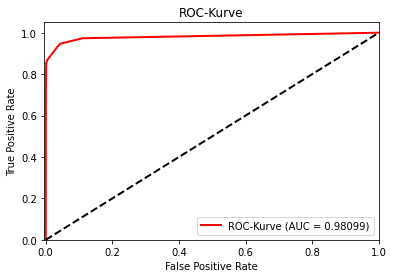

In [17]:

#----------------------------
#Konfusions Matrix und ROC-Kurve
c = 0.35
class_names = ['Fehlerfrei', 'Fehlerhaft']
confusion_matrix1, report1, precision1, recall1 = get_confusion_matrix(X_tra, y_tra, dt_hyp_search_result, class_names, c)
print('Die Konfusionsmatrix ergibt sich wie folgt:\n {}.'.format(confusion_matrix1))
print('Der precision-score ist {}.'.format(round(precision1,3)))
print('Der recall-score ist {}.'.format(round(recall1,3)))

roc_curve_func(X_tra, y_tra, dt_hyp_search_result)


#### Veranschaulichung der Entscheidungsregeln des (besten) Decsion-Trees 

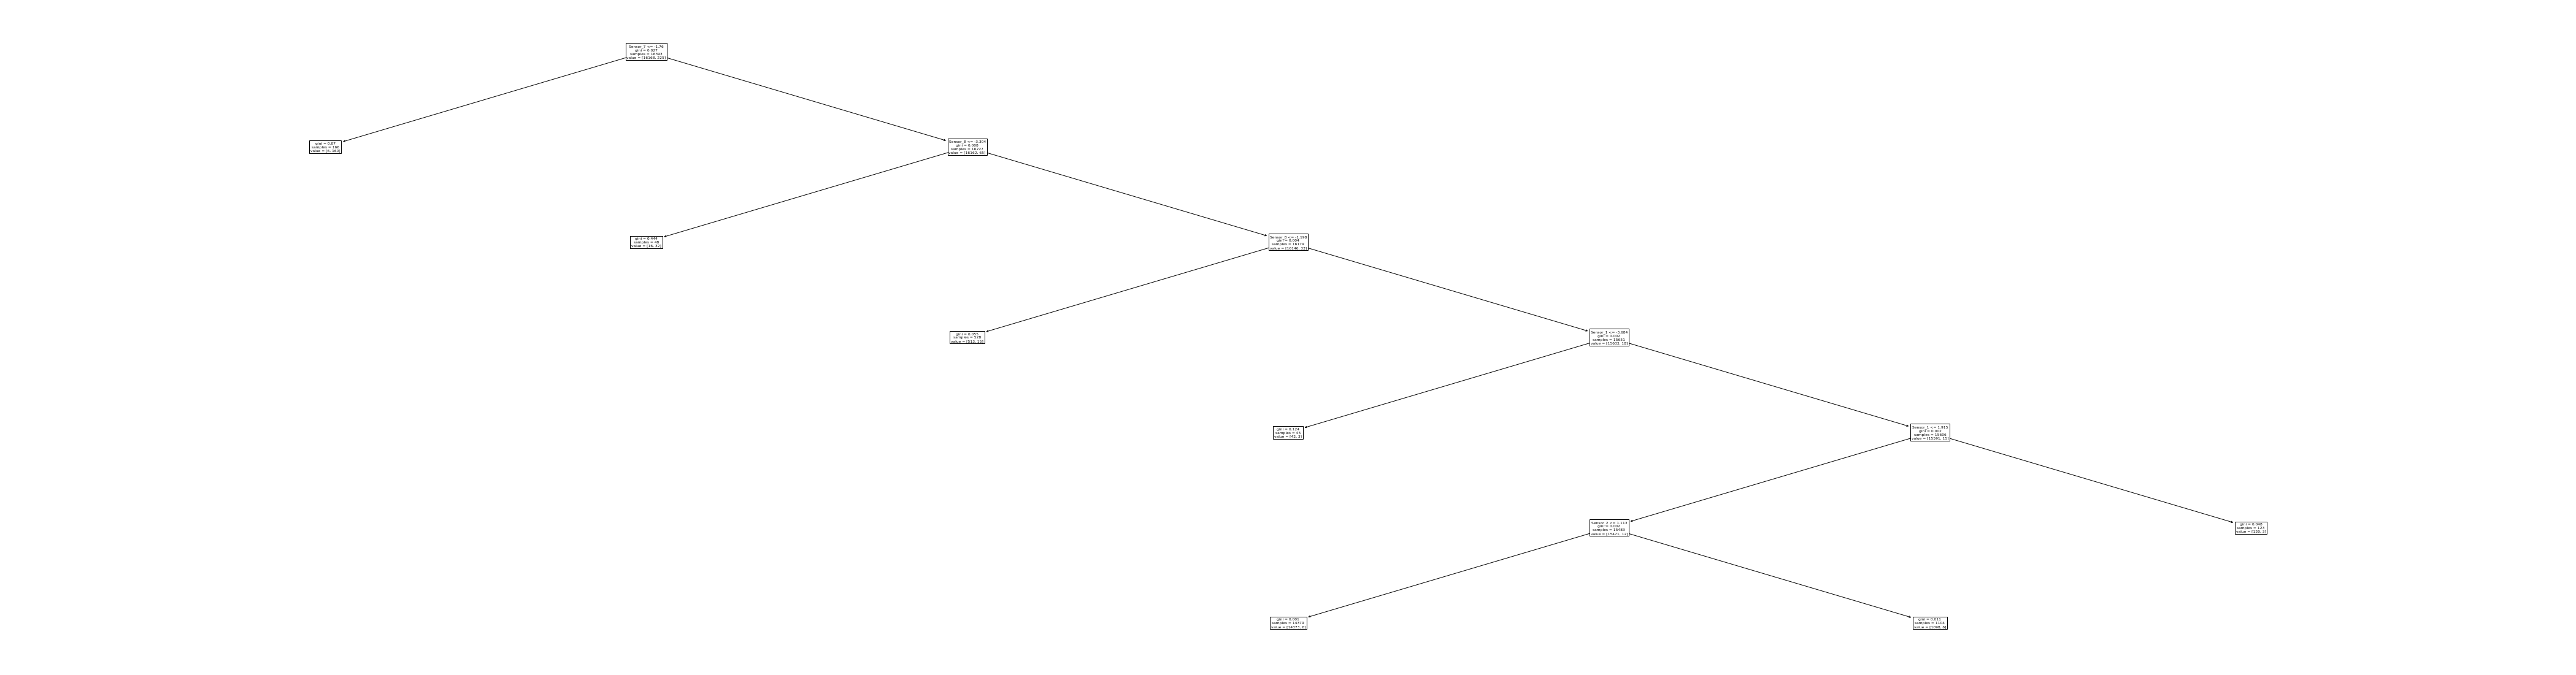

In [18]:

#--------------------------------
# Decision Tree plotten
fig, ax = plt.subplots(figsize=(75, 20))
tree.plot_tree(dt_hyp_search_result.best_estimator_.fit(X_tra, y_tra), fontsize=6, feature_names=X_train.columns)
plt.savefig('best_dt_model', quality=100, dpi=125)


#### Evaluation des Modells auf dem Validierungsdatensatz

Die Konfusionsmatrix ergibt sich wie folgt:
                                 Prognose des Modells                    
                                 Stückgut fehlerfrei Stückgut fehlerhaft
Wahrer Wert Stückgut fehlerfrei                 4031                   9
            Stückgut fehlerhaft                   13                  46.
Der precision-score ist 0.836.
Der recall-score ist 0.78.


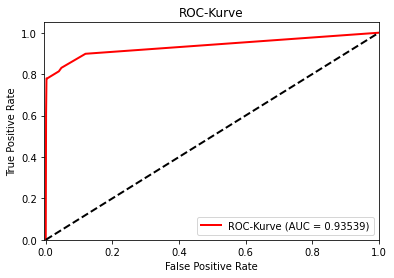

In [19]:

#----------------------------
#Konfusions Matrix and ROC-Curve
c = 0.35
class_names = ['Stückgut fehlerfrei', 'Stückgut fehlerhaft']
confusion_matrix2, report2, precision2, recall2 = get_confusion_matrix(X_val, y_val, dt_hyp_search_result, class_names, c)
print('Die Konfusionsmatrix ergibt sich wie folgt:\n {}.'.format(confusion_matrix2))
print('Der precision-score ist {}.'.format(round(precision2,3)))
print('Der recall-score ist {}.'.format(round(recall2,3)))

roc_curve_func(X_val, y_val, dt_hyp_search_result)


### Künstliches neuronales Netzwerk (Autoencoder)
#### Daten neu einlesen um Verzerrung zu vermeiden

In [20]:

data = pd.read_csv('train.csv', index_col=0)
#--------------------------------
# Erklärende und zu erklärende Variable(n) trennen und in Trainings- und Validierungset splitten
X_data = data.drop('Fehlerhaft', axis=1)
y_data = data['Fehlerhaft']
X_train, X_validierung, y_train, y_validierung = train_test_split(X_data, y_data, test_size=0.2, random_state=2121)

#--------------------------------
# Traingsdatensatz vom DataFrame-Format in ein Array überführen und skalieren
X_tra, y_tra, my_scaler_from_train = prepare_data(X_train, y_train, my_scaler=StandardScaler(), val=False)
#----------------------------
# Validierungsdaten vom DataFrame-Format in ein Array überführen und skalieren
X_val, y_val, _ = prepare_data(X_validierung, y_validierung, my_scaler=my_scaler_from_train, val=True)


#### Modell-Definition

In [21]:

#----------------------------
# Modell definieren
def create_model(input_dim=X_train.shape[1], encoding_dim=X_train.shape[1],
                 bottleneck_dim=int(X_train.shape[1] / 2), hidden_layers=2,
                 bottleneck_activation='relu', normal_activation='relu',
                 my_optimizer='adam', my_loss='mean_squared_error', my_metrics=['accuracy']):
    
    model = Sequential()

    model.add(Dense(input_dim, activation=normal_activation))
    
    for i in range(1, (hidden_layers + 1)):

        model.add(Dense(bottleneck_dim, activation=bottleneck_activation))

    model.add(Dense(input_dim, activation=normal_activation))

    model.compile(optimizer=my_optimizer, 
                  loss=my_loss, metrics=["accuracy"])    
   
    return model


#### Modell- und Parameter-Definition

In [22]:

#--------------------------------
# Erstellung Dictonary mit parametern
knn_param_grid = {'batch_size': [25, 40, 60, 100],
                  'epochs': [25, 75, 150, 500, 1000],
                  'hidden_layers': [1,2,3],
                  'bottleneck_dim': [int(X_train.shape[1] / 2), int(X_train.shape[1] / 4)],
                  'bottleneck_activation': ['relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear', 'softmax', 'softplus', 'softsign'] ,
                  'normal_activation': ['relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear', 'softmax', 'softplus', 'softsign'] 
                 }

#--------------------------------
# Modell erstellen
knn_model = KerasClassifier(build_fn=create_model, verbose=0)


#### Hyperparametersuche

In [23]:

#----------------------------
# RandomizedSearchCV starten
knn_hyp_search = RandomizedSearchCV(estimator=knn_model, param_distributions=knn_param_grid, cv=3, random_state=0, n_iter=15, verbose=2, n_jobs=-3)
knn_hyp_search_result = knn_hyp_search.fit(X_tra, X_tra)

#----------------------------
# Score und beste Parameterkombination ausgeben
print("Modells best score: {}.".format(round(knn_hyp_search_result.best_score_,5)))
print("Modells best parameter:\n{}.".format(knn_hyp_search_result.best_params_))


Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 10 concurrent workers.
C:\Users\Pablo\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-3)]: Done  21 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-3)]: Done  45 out of  45 | elapsed:  7.3min finished


Modells best score: 0.53492.
Modells best parameter:
{'normal_activation': 'softmax', 'hidden_layers': 3, 'epochs': 500, 'bottleneck_dim': 2, 'bottleneck_activation': 'softplus', 'batch_size': 25}.


#### Visualisierung der Modell-History

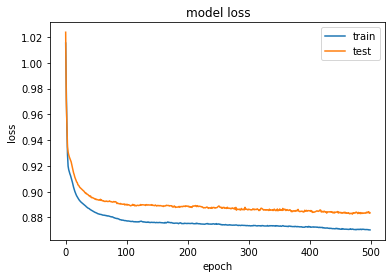

In [24]:

#----------------------------
# Modell-History plotten
_ = history_func(knn_hyp_search_result.best_estimator_, X_train=X_tra, X_test=X_val, verbose=0)


#### Evaluation des Modells auf dem Traingsdatensatz

       reconstruction_error    true_class
count          16393.000000  16393.000000
mean               0.869920      0.013725
std                4.924612      0.116352
min                0.006345      0.000000
25%                0.171290      0.000000
50%                0.301335      0.000000
75%                0.597404      0.000000
max              149.143245      1.000000


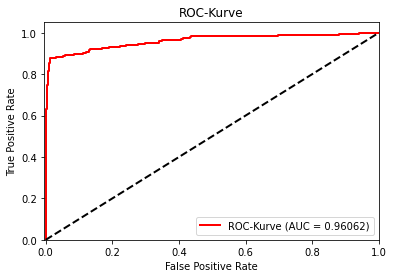

In [25]:

#----------------------------
# Prognosewerte ermitteln
predictions = knn_hyp_search_result.predict_proba(X_tra)

#----------------------------
# Error DataFrame erzeugen und beschreiben
mse = np.mean(np.power(X_tra - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                         'true_class': y_tra})
    
print(error_df.describe())

#----------------------------
# ROC-Curve und AUC anzeigen
roc_curve_func(error_df.true_class, error_df.reconstruction_error, model=None, predict=False)


#### Evaluation des Modells auf dem Validierungsdatensatz

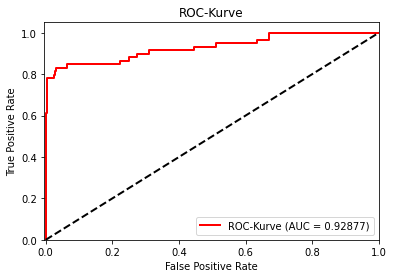

In [26]:

#----------------------------
# Prognosewerte ermitteln
predictions_val = knn_hyp_search_result.predict_proba(X_val)

#----------------------------
# Error DataFrame erzeugen und anzeigen
mse_val = np.mean(np.power(X_val - predictions_val, 2), axis=1)
error_df_val = pd.DataFrame({'reconstruction_error': mse_val,
                             'true_class': y_val})

#----------------------------
# ROC-Curve und AUC anzeigen
roc_curve_func(error_df_val.true_class, error_df_val.reconstruction_error, model=None, predict=False)


### "Überwindung" der Black-Box
#### Ausgabe der oberen Quantile des Error-DataFrame zur Abschätzung des Threshold

In [27]:

#----------------------------
# Quantile im Error-DF ermitteln
quantil = error_df.reconstruction_error.to_list()
for i in range(90, 100 + 1):
    q = i/100
    print('Quantil: {}, Value: {}.'.format(q, np.quantile(quantil, q)))


Quantil: 0.9, Value: 1.030860693786845.
Quantil: 0.91, Value: 1.0843841241214662.
Quantil: 0.92, Value: 1.1526345717220494.
Quantil: 0.93, Value: 1.2245193512995929.
Quantil: 0.94, Value: 1.3190111168164171.
Quantil: 0.95, Value: 1.4360986119935992.
Quantil: 0.96, Value: 1.6403325105918094.
Quantil: 0.97, Value: 2.079219821026544.
Quantil: 0.98, Value: 3.694143265897793.
Quantil: 0.99, Value: 9.579006225579656.
Quantil: 1.0, Value: 149.1432448284648.


#### Festlegung Threshold und binäre Transformation der Predictions

In [28]:

#----------------------------
# Predictions in binäre Werte überführen
threshold = np.quantile(quantil, 0.99)
y_pred_for_dt = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]


#### Evaluation des Decision-Tree-Modells auf den transformierten Predictions

Die Konfusionsmatrix ergibt sich wie folgt:
                        Prognose des Modells           
                                 Fehlerfrei Fehlerhaft
Wahrer Wert Fehlerfrei                16156         73
            Fehlerhaft                   23        141.
Der precision-score ist 0.659.
Der recall-score ist 0.86.


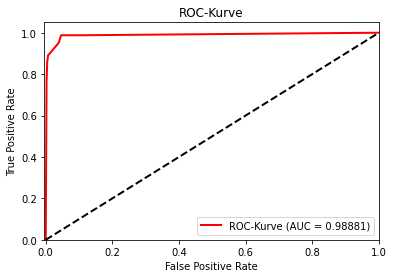

In [29]:

#----------------------------
#Konfusions Matrix and ROC-Curve
c = 0.35
class_names = ['Fehlerfrei', 'Fehlerhaft']
confusion_matrix3, report3, precision3, recall3 = get_confusion_matrix(X_tra, y_pred_for_dt, dt_hyp_search_result, class_names, c)
print('Die Konfusionsmatrix ergibt sich wie folgt:\n {}.'.format(confusion_matrix3))
print('Der precision-score ist {}.'.format(round(precision3,3)))
print('Der recall-score ist {}.'.format(round(recall3,3)))

roc_curve_func(X_tra, y_pred_for_dt, dt_hyp_search_result)


#### Veranschaulichung der Entscheidungsregeln des Decsions Trees auf  Bais der transformierten Predictions

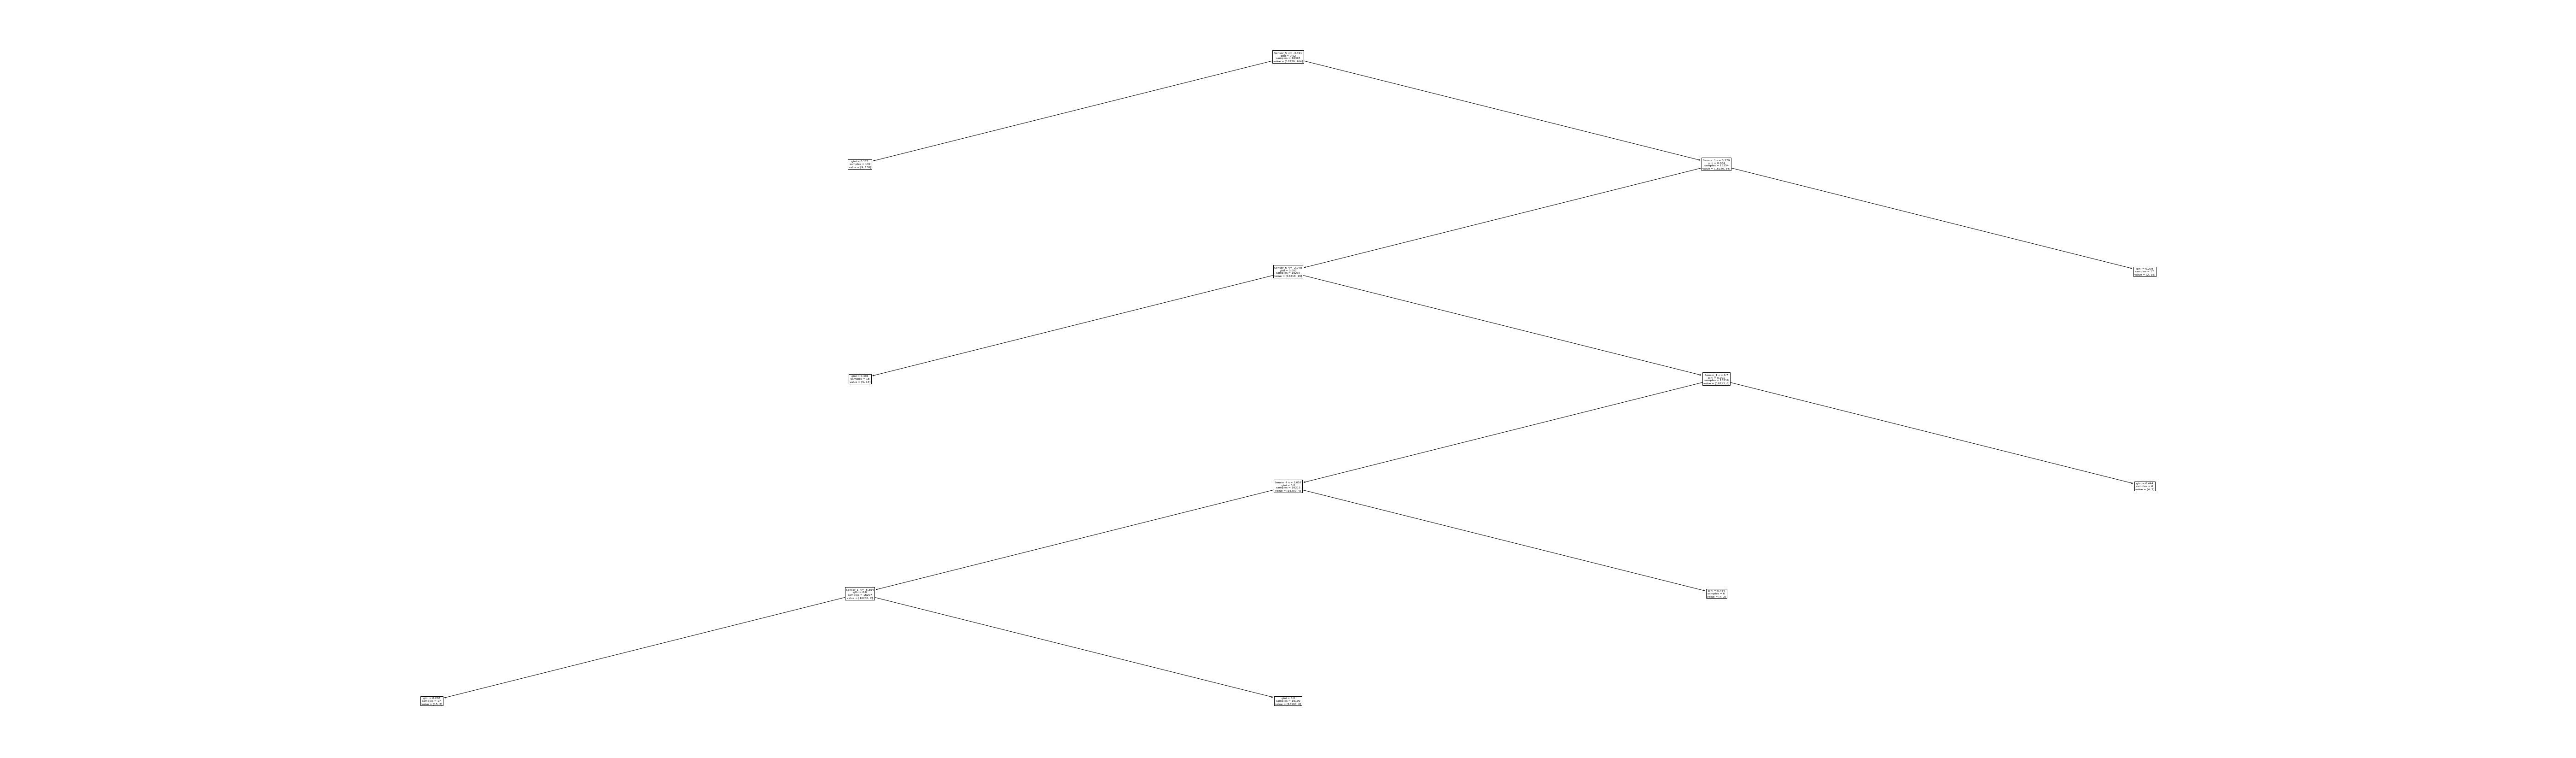

In [30]:

#--------------------------------
# Decision Tree plotten
fig, ax = plt.subplots(figsize=(100, 30))
tree.plot_tree(dt_hyp_search_result.best_estimator_.fit(X_tra, y_pred_for_dt), fontsize=6, feature_names=X_train.columns)
plt.savefig('best_knn_dt_model', quality=100, dpi=125)


## Benchmark: Out-of-the-Box Autoencoder von PyOD

In [31]:

#--------------------------------
# Modell definieren
pyod_model = AutoEncoder(batch_size=64, # Number of samples per gradient update
                    contamination=0.01386, # The proportion of outliers in the data set
                    dropout_rate=0.25, # The dropout to be used across all layers
                    epochs=50, # Number of epochs to train the model
                    hidden_activation='relu', # Activation function to use for hidden layers (same for all)
                    hidden_neurons=[(X_train.shape[1])//4], # The number of neurons per hidden layers
                    l2_regularizer=0.1, # The regularization strength of activity_regularizer applied on each layer
                    loss='mean_squared_error', #  String (name of objective function) or objective function.
                    optimizer='adam', # String (name of optimizer) or optimizer instance
                    output_activation='linear', # Activation function to use for output layer
                    preprocessing=False, # If True, apply standardization on the data
                    random_state=1337, # Seed for random number generator
                    validation_size=0.0, # The percentage of data to be used for validation
                    verbose=0) # Verbosity mode


Model Information: AutoEncoder(batch_size=64, contamination=0.01386, dropout_rate=0.25,
      epochs=50, hidden_activation='relu', hidden_neurons=[2],
      l2_regularizer=0.1, loss='mean_squared_error', optimizer='adam',
      output_activation='linear', preprocessing=False, random_state=1337,
      validation_size=0.0, verbose=0)

Evaluation on Training Data:
Scores: ROC:0.963, precision @ rank n:0.68


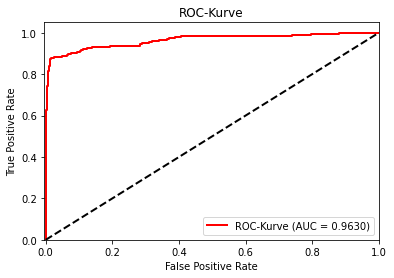

In [32]:

#--------------------------------
# Modell fitten und Scores ermitteln
_ = pyod_model.fit(X_tra)
y_train_scores = pyod_model.decision_scores_

#--------------------------------
# Modell evaluieren
_ = evaluate_func(model=pyod_model, true=y_tra, scores=y_train_scores)


### Evaluation des Modells auf den Testdaten

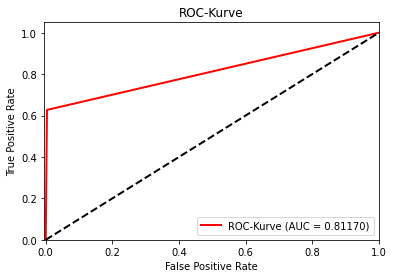

In [33]:

#--------------------------------
# Prognose auf den Validierungsdaten und Evaluation
pyod_predictions = pyod_model.predict(X_val)
roc_curve_func(y_val, pyod_predictions, model=None, predict=False)


## Modelle speichern (und laden)

In [34]:

#--------------------------------
# Decision-Tree-Modell
_ = joblib.dump(dt_hyp_search_result.best_estimator_, 'dt_hyp_search_result.pkl')
#--------------------------------
# Autoencoder
_ = joblib.dump(knn_hyp_search_result.best_estimator_, 'knn_hyp_search_result.pkl')


In [35]:

#--------------------------------
# Decision Tree Modell laden
loaded_dt_model = joblib.load('dt_hyp_search_result.pkl')
dt_result = loaded_dt_model.score(X_tra, y_tra)
print(dt_result)


0.9933508204721527
